In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yaml
from IPython.display import Image
from matplotlib.patches import Rectangle, Polygon

from config import SPECS_PF_OPTION_YAMLS, FIG_RESULTS_DIR
from drawutil import mpl_config
from util import get_Theta_cos

In [2]:
# global setting
SCALE = 1.0 # scale = 1.0 for write-up dimensions
mpl_config(SCALE)

In [3]:
# outputs
os.makedirs(FIG_RESULTS_DIR, exist_ok=True)
lpac_geometries_jpg = os.path.join(FIG_RESULTS_DIR, 'ijoc-lpac-geometries.jpg')
lpac_geometries_eps = os.path.join(FIG_RESULTS_DIR, 'ijoc-lpac-geometries.eps')
cosine_geometry_comparison_jpg = os.path.join(FIG_RESULTS_DIR, 'ijoc-cosine-geometry-comparison.jpg')
cosine_geometry_comparison_eps = os.path.join(FIG_RESULTS_DIR, 'ijoc-cosine-geometry-comparison.eps')

In [12]:
FEASIBLE_COLOR = 'gray'
ACTUAL_COLOR = 'black'
BOUNDARY_COLOR = 'lightgray'


def make_cosine_plot():
    fig = plt.figure(figsize=(6, 4))
    ax = plt.gca()
    return fig, ax


def make_disc_plot():
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()
    return fig, ax


def config_cosine_plot(ax, margin_factor=None):
    if margin_factor is None:
        margin_factor = 0.125
    ax.set_xlim(-np.pi / 2 * (1 + margin_factor), np.pi / 2 * (1 + margin_factor))
    ax.set_xticks([-np.pi / 2, np.pi / 2])
    ax.set_xticklabels(['$-\pi/2$', '$\pi/2$'])
    ax.set_xlabel('$\\theta_n - \\theta_m$')
    ax.set_ylim(0 - 1 * margin_factor, 1 + 1 * margin_factor)
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1])
    ax.set_ylabel('$\\widehat{\\cos}_{nm}$', rotation=0)


def config_disc_plot(ax, margin_factor=None):
    if margin_factor is None:
        margin_factor = 0.125
    ax.set_xlim(-1 - 2 * margin_factor, 1 + 2 * margin_factor)
    ax.set_ylim(-1 - 2 * margin_factor, 1 + 2 * margin_factor)
    ax.set_xticks([-1, 1])
    ax.set_yticks([-1, 1])
    ax.set_xticklabels([r'$-\overline{s}_l^\mathrm{flow}$', r'$\overline{s}_l^\mathrm{flow}$'])
    ax.set_yticklabels([r'$-\overline{s}_l^\mathrm{flow}$', r'$\overline{s}_l^\mathrm{flow}$'])
    ax.set_xlabel('$\\tilde{p}_l$')
    ax.set_ylabel('$\\tilde{q}_l$', rotation=0)


def cosine_constant(ax, theta_delta_max=np.pi/2):
    x = np.linspace(-theta_delta_max, theta_delta_max, 1000)
    ax.plot(x, np.cos(x), '-', color=ACTUAL_COLOR)
    ax.plot(x, np.ones(shape=x.shape), '--', color=BOUNDARY_COLOR)
    config_cosine_plot(ax)


def cosine_linear(ax, margin_factor=None, theta_delta_max=None, Theta_cos=None):
    if margin_factor is None:
        margin_factor = 0.125
    if theta_delta_max is None:
        theta_delta_max = np.pi / 2
    if Theta_cos is None:
        Theta_cos = np.linspace(-theta_delta_max, theta_delta_max, 7)
    x = np.linspace(-(1 + margin_factor) * theta_delta_max, (1 + margin_factor) * theta_delta_max, 1000)
    y = np.ones(shape=x.shape)
    _ys = []
    for theta in Theta_cos:
        x_hat = theta
        y_hat = np.cos(x_hat)
        slope = -np.sin(x_hat)
        _y = slope * (x - x_hat) + y_hat
        _ys.append(_y)
        y = np.minimum(y, _y)
    y = np.maximum(y, np.cos(theta_delta_max))
    ax.fill(x, y, color=FEASIBLE_COLOR)
    rectangle = Rectangle((-theta_delta_max, np.cos(theta_delta_max)),
                          2 * theta_delta_max, y.min() - np.cos(theta_delta_max), color=FEASIBLE_COLOR)
    ax.add_patch(rectangle)
    for _y in _ys:
        ax.plot(x, _y, '--', color=BOUNDARY_COLOR)
    ax.plot([-theta_delta_max] * 2, [0 - 1 * margin_factor, 1 + 1 * margin_factor], '--', color=BOUNDARY_COLOR)
    ax.plot([ theta_delta_max] * 2, [0 - 1 * margin_factor, 1 + 1 * margin_factor], '--', color=BOUNDARY_COLOR)
    ax.plot([x.min(), x.max()], [np.cos(theta_delta_max)] * 2, '--', color=BOUNDARY_COLOR)
    ax.plot(x, np.cos(x), '-', color=ACTUAL_COLOR)
    config_cosine_plot(ax)


def cosine_quadratic(ax, theta_delta_max=None):
    if theta_delta_max is None:
        theta_delta_max = np.pi / 2
    x = np.linspace(-theta_delta_max, theta_delta_max, 1000)
    y = 1 - (1 - np.cos(theta_delta_max)) / theta_delta_max ** 2 * x ** 2
    ax.fill(x, y, color=FEASIBLE_COLOR)
    ax.plot(x, y, '--', color=BOUNDARY_COLOR)
    ax.plot([-theta_delta_max,  theta_delta_max], [np.cos(x).min()] * 2, '--', color=BOUNDARY_COLOR)
    ax.plot(x, np.cos(x), '-', color=ACTUAL_COLOR)
    config_cosine_plot(ax)


def disc_linear(ax, Theta_disc=None):
    if Theta_disc is None:
        Theta_disc = np.arange(0, 2 * np.pi, np.pi / 4)
    # compute the boundaries
    for theta in Theta_disc:
        x0, y0, m = np.cos(theta), np.sin(theta), np.tan(theta + np.pi / 2)
        if m < 1e6:
            x = np.linspace(-2, 2, 2)
            y = m * (x - x0) + y0
            ax.plot(x, y, '--', color=BOUNDARY_COLOR)
        else:
            y = np.linspace(-2, 2, 2)
            x = (y - y0) / m + x0
            ax.plot(x, y, '--', color=BOUNDARY_COLOR)
    # compute the feasible region
    xs, ys = [], []
    i = 0
    for theta0, theta1 in zip([Theta_disc[-1], *Theta_disc], [*Theta_disc, Theta_disc[0]]):
        x0, y0, m0 = np.cos(theta0), np.sin(theta0), np.tan(theta0 + np.pi / 2)
        x1, y1, m1 = np.cos(theta1), np.sin(theta1), np.tan(theta1 + np.pi / 2)
        if np.isclose(theta0, 0) or np.isclose(theta0, np.pi):
            x = np.cos(theta0)
            y = m1 * (x - x1) + y1            
        elif np.isclose(theta1, 0) or np.isclose(theta1, np.pi):
            x = np.cos(theta1)
            y = m0 * (x - x0) + y0
        else:
            x = ((m0 * x0 - y0) - (m1 * x1 - y1)) / (m0 - m1)
            y = m0 * (x - x0) + y0
        xs, ys = xs + [x], ys + [y]
    # plot everything
    feasible = Polygon(list(zip(xs, ys)), color=FEASIBLE_COLOR)
    ax.add_patch(feasible)
    circle = plt.Circle((0, 0), 1, facecolor=ACTUAL_COLOR, edgecolor=FEASIBLE_COLOR, hatch='')
    ax.add_patch(circle)
    config_disc_plot(ax)


def disc_quadratic(ax):
    circle = plt.Circle((0, 0), 1, facecolor=ACTUAL_COLOR, edgecolor=FEASIBLE_COLOR, hatch='')
    ax.add_patch(circle)
    circle = plt.Circle((0, 0), 1, linestyle='--', facecolor='none', edgecolor=BOUNDARY_COLOR)
    ax.add_patch(circle)
    config_disc_plot(ax)

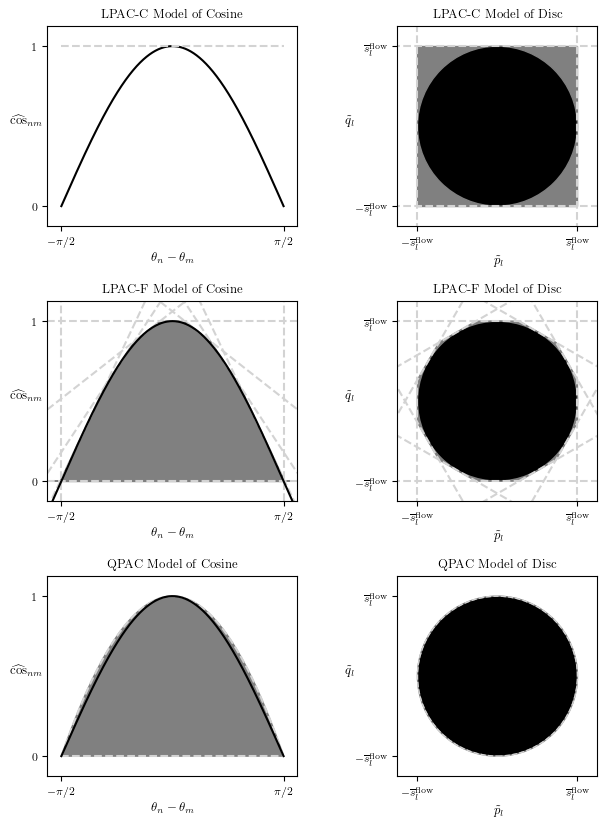

In [13]:
n_rows = 3
n_cols = 2

ax_w = [2.5, 2]
ax_h = [2] * 3
ws_w = [0.75, 1.00, 0.25]
ws_h = [0.50, 0.75, 0.75, 0.25]
fig_w = sum(ax_w) + sum(ws_w)
fig_h = sum(ax_h) + sum(ws_h)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))

for ip in range(n_rows):
    for jp in range(n_cols):
        i, j = n_rows - 1 - ip, jp
        axes[ip, jp].set_position(((sum(ax_w[:j]) + sum(ws_w[:j+1])) / fig_w,
                                   (sum(ax_h[:i]) + sum(ws_h[:i+1])) / fig_h,
                                   ax_w[j] / fig_w,
                                   ax_h[i] / fig_h))

# Loose LPAC
with open(SPECS_PF_OPTION_YAMLS['lpacc']) as fh:
    specs = yaml.load(fh, Loader=yaml.Loader)
    Theta_disc = specs['options']['Theta_flow_limit']
cosine_constant(axes[0, 0])
disc_linear(axes[0, 1], Theta_disc=Theta_disc)

# Tight LPAC
with open(SPECS_PF_OPTION_YAMLS['lpacf']) as fh:
    specs = yaml.load(fh, Loader=yaml.Loader)
    Theta_cos = specs['options']['Theta_cos']
    Theta_disc = specs['options']['Theta_flow_limit']
cosine_linear(axes[1, 0], Theta_cos=Theta_cos)
disc_linear(axes[1, 1], Theta_disc=Theta_disc)

# QPAC
cosine_quadratic(axes[2, 0])
disc_quadratic(axes[2, 1])

# Subplot Titles
models = ['LPAC-C', 'LPAC-F', 'QPAC']
geometries = ['Cosine', 'Disc']
for (i, model) in zip(range(n_rows), models):
    for (j, geometry) in zip(range(n_cols), geometries):
        axes[i, j].set_title(f'{model} Model of {geometry}')

plt.savefig(lpac_geometries_jpg, format='jpg', dpi=600)
plt.savefig(lpac_geometries_eps, format='eps')
Image(lpac_geometries_jpg)

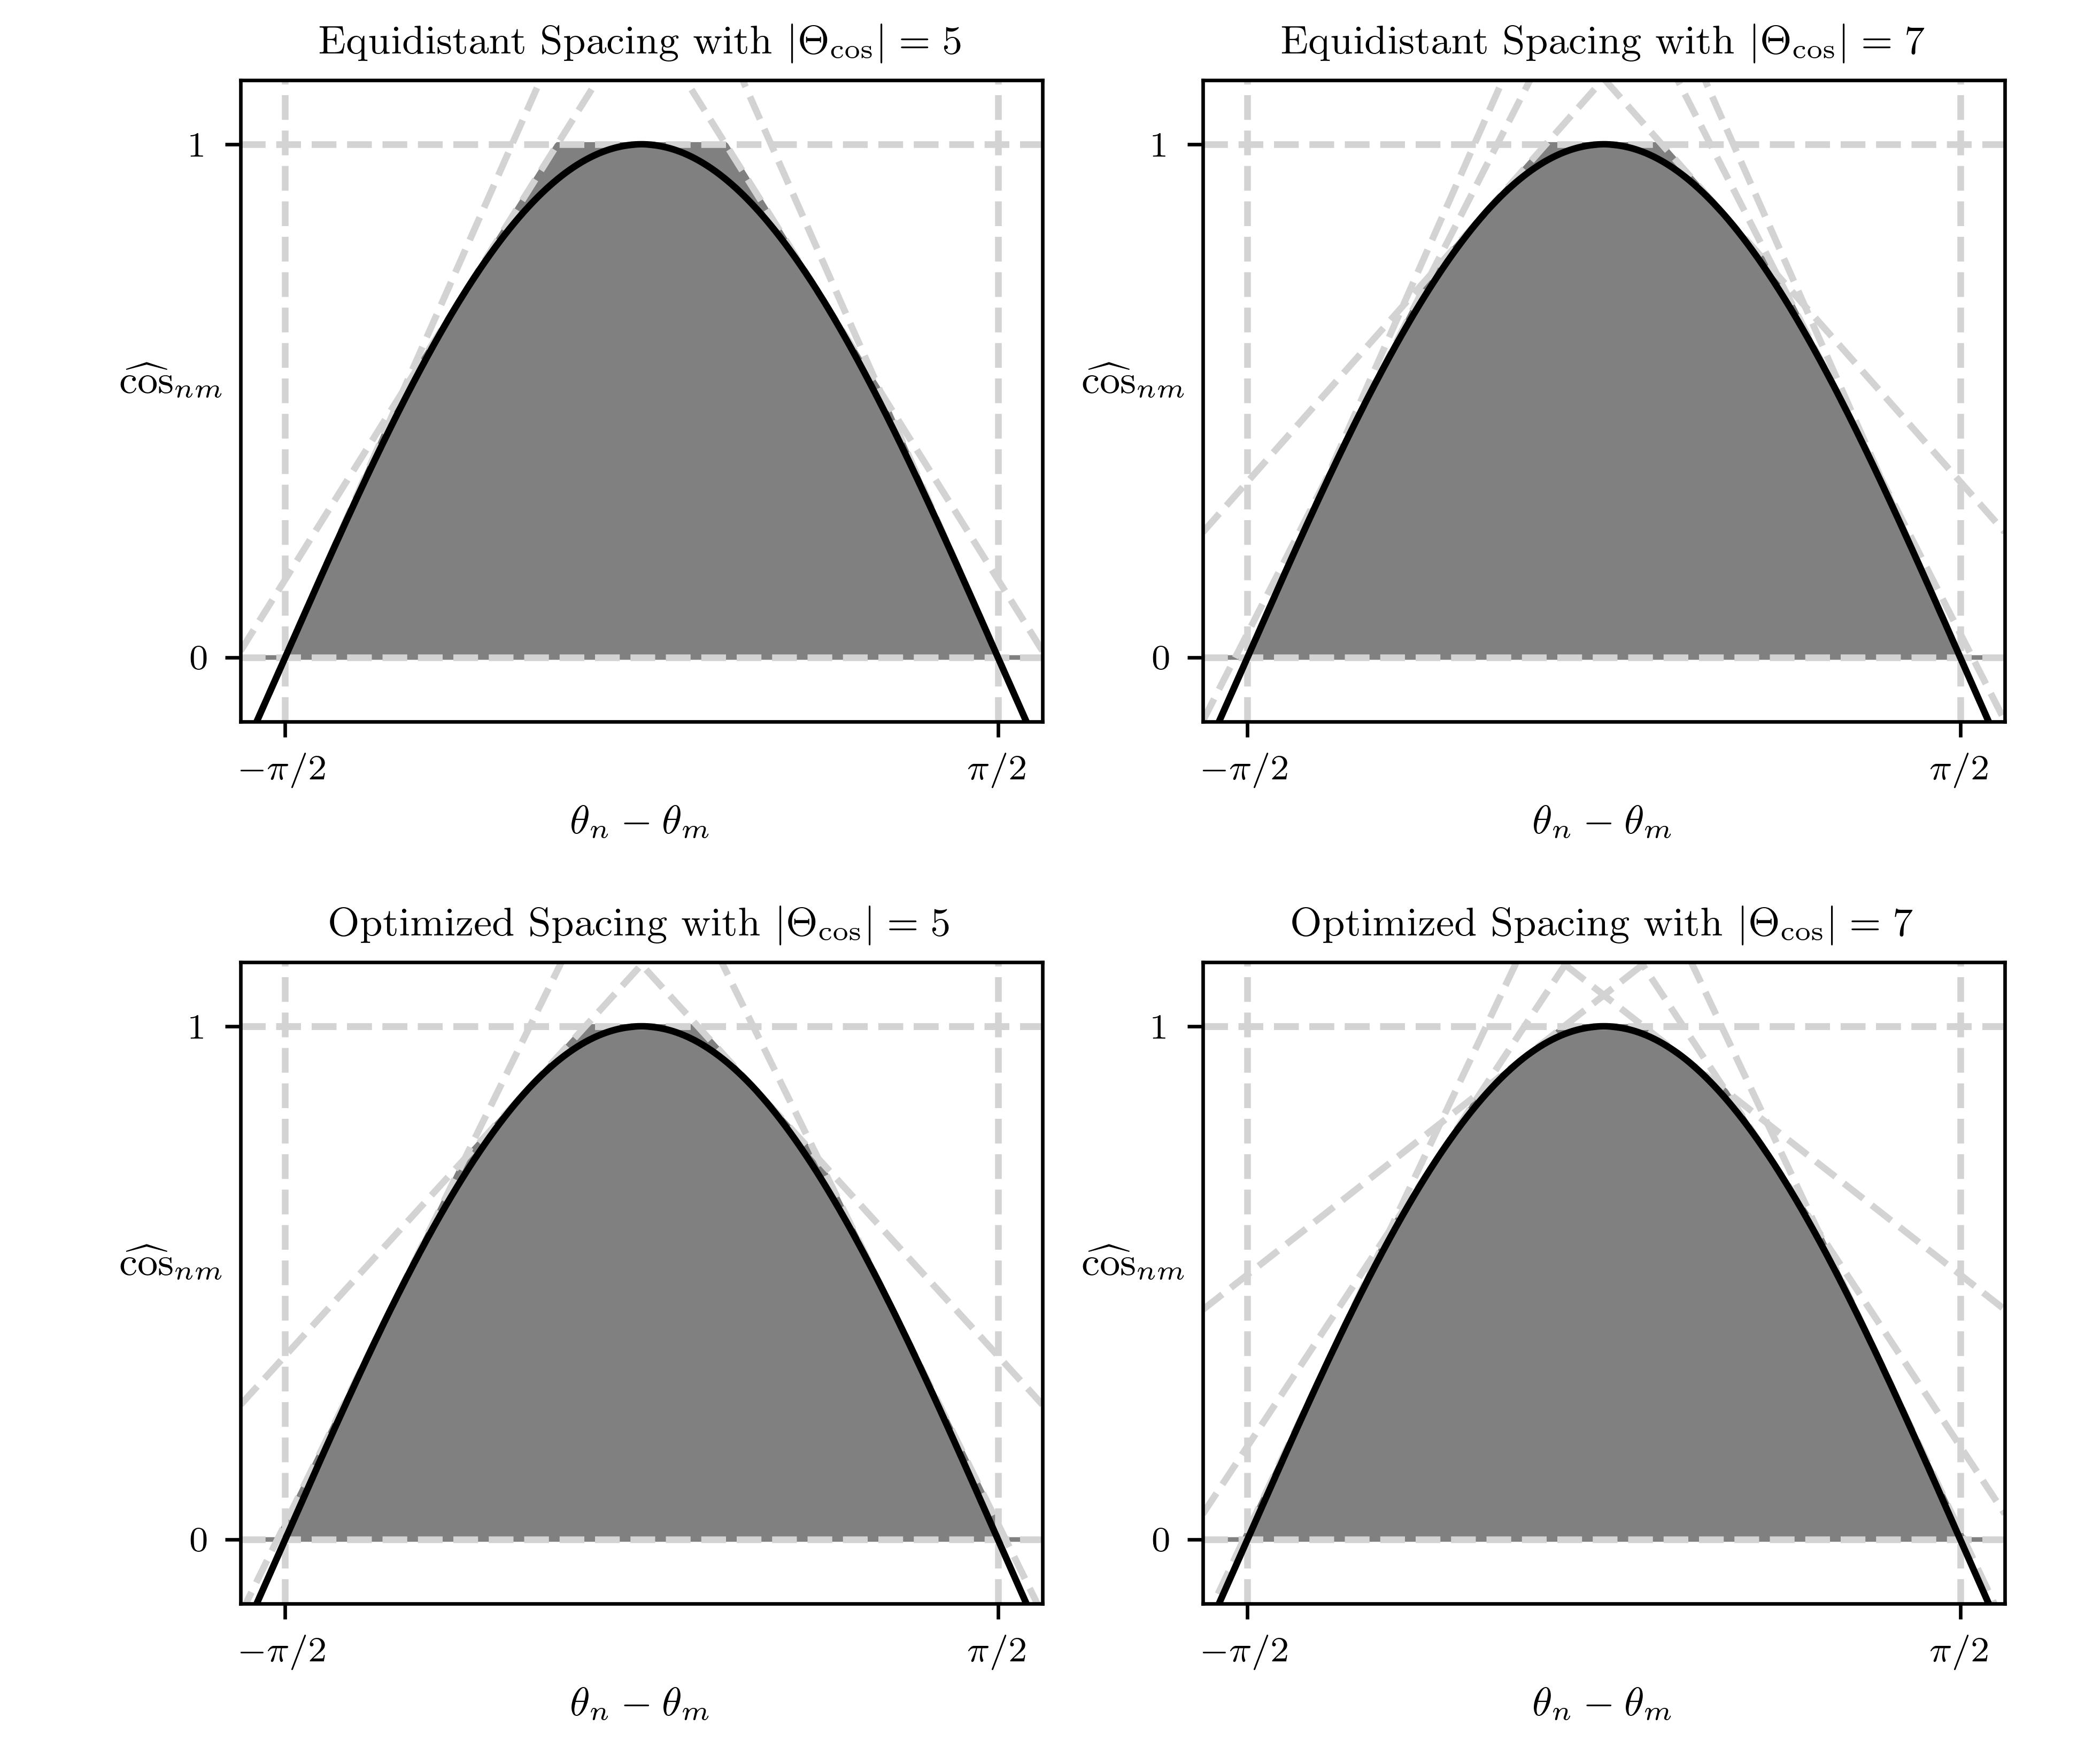

In [9]:
n_rows = 2
n_cols = 2

ax_w = [2.5] * 2
ax_h = [2] * 2
ws_w = [0.75, 0.50, 0.25]
ws_h = [0.50, 0.75, 0.25]
fig_w = sum(ax_w) + sum(ws_w)
fig_h = sum(ax_h) + sum(ws_h)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))

for ip in range(n_rows):
    for jp in range(n_cols):
        i, j = n_rows - 1 - ip, jp
        axes[ip, jp].set_position(((sum(ax_w[:j]) + sum(ws_w[:j+1])) / fig_w,
                                   (sum(ax_h[:i]) + sum(ws_h[:i+1])) / fig_h,
                                   ax_w[j] / fig_w,
                                   ax_h[i] / fig_h))

cosine_linear(axes[0, 0], Theta_cos=np.linspace(-np.pi / 2, np.pi / 2, 5))
axes[0, 0].set_title(r'Equidistant Spacing with $|\Theta_{\mathrm{cos}}| = 5$')

Theta_cos = list(get_Theta_cos(3, fix_first_theta_hat=True, fix_last_theta_hat=False, theta_delta_max=np.pi/2))
Theta_cos.extend([-theta for theta in Theta_cos if theta != 0])
cosine_linear(axes[1, 0], Theta_cos=sorted(Theta_cos))
axes[1, 0].set_title(r'Optimized Spacing with $|\Theta_{\mathrm{cos}}| = 5$')


cosine_linear(axes[0, 1], Theta_cos=np.linspace(-np.pi / 2, np.pi / 2, 7))
axes[0, 1].set_title(r'Equidistant Spacing with $|\Theta_{\mathrm{cos}}| = 7$')

Theta_cos = list(get_Theta_cos(4, fix_first_theta_hat=True, fix_last_theta_hat=False, theta_delta_max=np.pi/2))
Theta_cos.extend([-theta for theta in Theta_cos if theta != 0])
cosine_linear(axes[1, 1], Theta_cos=sorted(Theta_cos))
axes[1, 1].set_title(r'Optimized Spacing with $|\Theta_{\mathrm{cos}}| = 7$')

plt.savefig(cosine_geometry_comparison_jpg, format='jpg', dpi=600)
plt.savefig(cosine_geometry_comparison_eps, format='eps')
Image(cosine_geometry_comparison_jpg)